---
# Title : Disease Detection using Faster R-CNN with Python
---

## STEP 0. 환경설정

In [23]:
# GPU 확인. 코랩에서는 랜덤 GPU할당되므로 메모리 부족현상 발생 가능 -> GPU확인 후 메모리 충분할 경우 진행 권장

import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [24]:
# 라이브러리 임포트

import os
import glob
import json
import shutil as util

# 바운딩박스 도식화 위한 패키지 임포트
import glob  # 파일, 디렉토리 처리
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  # matplotlib 시각화
import matplotlib.patches as patches
from bs4 import BeautifulSoup  # HTML, XML 파일 파싱, 웹스크래핑 

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision  # 이미지 처리를 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지 내장
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

import random

from tqdm import tqdm
import pandas as pd
from collections import Counter

from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## STEP 1. 데이터 준비

### S1-1P. 데이터 불러오기(농작물병해)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [25]:
# %cd /content/drive/MyDrive/aiffelthon/PjtDataset/train
# !pwd

# train = glob.glob('*')
# print("train:",train)
# print(len(train))
# print(train[40])
# sample = glob.glob('train')
# print(len(sample))

# # train_image_sample = cv2.imread(glob.glob('train[40]'+'/*.jpg')[0])
# train_json_sample = json.load(open(glob.glob(train[40]+'/*.json')[0], 'r'))

# %cd /content/drive/MyDrive/aiffelthon/PjtDataset/train
# !pwd
# f_names = glob.glob('*')
# print(len(f_names))
# sample = f_names[40]

# sample_train_image = cv2.imread(glob.glob(sample+'/*.jpg')[0])
# print(sample_train_image)
# # train_json_sample = json.load(open(glob.glob(train[42]+'/*.json')[0], 'r'))

# with open((sample_train_image, "r") as json_file:
#     sample_train_json = json.load(open(glob.glob(sample+'/*.json')[0], 'r'))
#     sample_train_json['annotations'].append({
#     "label": "1_00_0"
#     })

/content/drive/MyDrive/aiffel/Datathon/data/train
/content/drive/MyDrive/aiffel/Datathon/data/train
train: ['58063', '58067', '58075', '58079', '58092', '58096', '58098', '58111', '58122', '58134', '58146', '58148', '58157', '58166', '58182', '58211', '58223', '58185', '58232', '58235', '58242', '58245', '58255', '58257', '58263', '58269', '58273', '58276', '58287', '58291', '58322', '58329', '58334', '58342', '58338', '58350', '58375', '58401', '58403', '58418', '58364', '58421', '58382', '58424', '58439', '58446', '58464', '58413', '58470', '58475', '58483', '58422', '58489', '58492', '58501', '58505', '58514', '58520', '58537', '58550', '58551', '58564', '58572', '58590', '58614', '58630', '58599', '58677', '58678', '58649', '58679', '58687', '58691', '58698', '58706', '58716', '58720', '58726', '58734', '58735', '58724', '58765', '58781', '58820', '58837', '58841', '58822', '58844', '58856', '58868', '58849', '58880', '58887', '58860', '58890', '58894', '58915', '58938', '58950', '

In [27]:
# # image
# plt.imshow(cv2.cvtColor(train_image_sample, cv2.COLOR_BGR2RGB))
# plt.show()

error: ignored

In [ ]:
# # json
# print(train_json_sample)
# print(train_json_sample['annotations']['area'])

{'description': {'date': '20211018', 'image': '58364.jpg', 'task': 0, 'width': 384, 'time': '1712', 'region': 0, 'height': 512}, 'annotations': {'area': 1, 'disease': '00', 'grow': 13, 'bbox': [{'x': 34.095238095238095, 'h': 277.7709263392857, 'y': 135.61904761904762, 'w': 313.7679811507937}], 'part': [], 'risk': 0, 'crop': 2}}
1


### S1-2P.바운딩박스

In [ ]:
# # visualize bbox
# plt.figure(figsize=(7,7))
# points = sample_json['annotations']['bbox'][0]
# part_points = sample_json['annotations']['part']
# img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# cv2.rectangle(
#     img,
#     (int(points['x']), int(points['y'])),
#     (int((points['x']+points['w'])), int((points['y']+points['h']))),
#     (0, 255, 0),
# )
# for part_point in part_points:
#     point = part_point
#     cv2.rectangle(
#         img,
#         (int(point['x']), int(point['y'])),
#         (int((point['x']+point['w'])), int((point['y']+point['h']))),
#         (255, 0, 0),
#         1
#     )
# plt.imshow(img)
# plt.show()

### S1-3P. label 만들기


In [28]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [29]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [30]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [71]:
print(label_encoder['1_00_0'])

0


### S1-1B. 데이터 불러오기(마스크)

In [ ]:
# # 데이터로더 파일이 들어 있는 유틸리티 파일을 clone하고
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

# # 데이터로더 파일을 실행시켜 데이터셋을 다운로드 받음. --data 옵션에 FaceMaskDetection 파라미터를 줌
# !python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1pJtohTc9NGNRzHj5IsySR39JIRPfkgD3
To: /content/Face Mask Detection.zip
100% 417M/417M [00:01<00:00, 229MB/s]
Face Mask Detection.zip download complete!


In [ ]:
# # 다운받은 파일 압축 풀기

# !unzip -q Face\ Mask\ Detection.zip

replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### S1-2. 데이터 분리
* 데이터셋에서 훈련셋과 시험셋을 나눠줌
* 일반적으로 훈련셋:시험셋은 7:3으로 나누지만, 데이터셋이 적을 때는 8:2로 나눠주기도 함


In [ ]:
# # 데이터셋을 불러서 학습셋과 시험셋으로 분리해 줌

# # 데이터의 갯수를 확인해 봄
# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))

# # 테스트셋을 저장할 폴더를 만들어줌
# !mkdir test_images
# !mkdir test_annotations

# # 랜덤하게 수를 발생시켜 인덱스로 사용하고, random.sample()함수를 사용해 훈련셋과 시험셋으로 나눔
# random.seed(1234)
# idx = random.sample(range(853), 170)

# for img in np.array(sorted(os.listdir('images')))[idx]:
#     shutil.move('images/'+img, 'test_images/'+img)

# for annot in np.array(sorted(os.listdir('annotations')))[idx]:
#     shutil.move('annotations/'+annot, 'test_annotations/'+annot)

# # 나눈 후 각각의 폴더에 있는 데이터 갯수를 확인해 봄
# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))
# print(len(os.listdir('test_annotations')))
# print(len(os.listdir('test_images')))

853
853
683
683
170
170


### S1-X. json파일 읽어서 label항목을 만들어 추가해 줌

In [3]:
# import glob
# train_annot_list = glob.glob('/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/*')
# print(train_annot_list)

['/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25038.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25051.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25056.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25062.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25041.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25068.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25082.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25085.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25096.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25099.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25102.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25106.json', '/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/25123.json', '/content/d

In [18]:
# import json
# for i, annot in enumerate(train_annot_list):

#     # if i == 10 :
#     #     break
#     with open(annot, "r") as file:
#         j_file = json.load(file)
#     # print(j_file)

#     label = str(j_file['annotations']['crop'])+"_"+str(j_file['annotations']['disease'])+"_"+str(j_file['annotations']['risk'])
#     print('i : ',i, ', label : ',label)
#     j_file['annotations']['label']=label 
#     # # j_file   
#     with open(annot, "w") as file:
#         json.dump(j_file, file)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
i :  757 , label :  2_a5_2
i :  758 , label :  4_00_0
i :  759 , label :  6_00_0
i :  760 , label :  5_b6_1
i :  761 , label :  3_00_0
i :  762 , label :  3_b3_1
i :  763 , label :  1_00_0
i :  764 , label :  5_b8_1
i :  765 , label :  6_00_0
i :  766 , label :  3_00_0
i :  767 , label :  5_b8_1
i :  768 , label :  3_b8_1
i :  769 , label :  3_00_0
i :  770 , label :  3_b6_1
i :  771 , label :  6_00_0
i :  772 , label :  6_00_0
i :  773 , label :  5_b8_1
i :  774 , label :  4_00_0
i :  775 , label :  3_b3_1
i :  776 , label :  3_a9_1
i :  777 , label :  3_00_0
i :  778 , label :  3_00_0
i :  779 , label :  3_00_0
i :  780 , label :  6_00_0
i :  781 , label :  3_00_0
i :  782 , label :  5_b7_1
i :  783 , label :  6_00_0
i :  784 , label :  6_a12_2
i :  785 , label :  2_a5_2
i :  786 , label :  3_a9_1
i :  787 , label :  3_00_0
i :  788 , label :  3_b6_1
i :  789 , label :  1_00_0
i :  790 , label :  3_a9_2
i :  791 , label :  4_00_0
i :  792 , label :

In [127]:

with open('/content/drive/MyDrive/aiffelthon/PjtDataset/train/annotations/58464.json', "r") as file:
    sample = json.load(file)
sample

{'description': {'date': '20210629',
  'image': '58464.jpg',
  'task': 1,
  'width': 242,
  'time': '1014',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'a9',
  'grow': 13,
  'bbox': [{'x': 0.20768846784319198,
    'h': 425.8128720238095,
    'y': 48.23661101810516,
    'w': 242.07803199404762}],
  'part': [{'x': 13.732194204179068,
    'h': 64.51026165674604,
    'y': 282.6316344246032,
    'id': 0,
    'w': 48.43593052455357},
   {'x': 133.38492063492063,
    'h': 34.06484064980159,
    'y': 230.15049913194446,
    'id': 1,
    'w': 37.89710441468254},
   {'x': 138.9204334077381,
    'h': 36.93905009920635,
    'y': 99.74607824900794,
    'id': 2,
    'w': 28.635757688492063},
   {'x': 90.69741288442461,
    'h': 27.14541480654762,
    'y': 204.28252108134922,
    'id': 3,
    'w': 38.53583829365079},
   {'x': 100.2781498015873,
    'h': 34.064825148809526,
    'y': 387.27452256944446,
    'id': 4,
    'w': 29.487366691468253},
   {'x': 197.7887214781746,

In [130]:
print(sample['annotations']['bbox'][0]['x'])

0.20768846784319198


In [131]:
print(sample['annotations']['part'][0]['x'])

13.732194204179068


### S1-3. 바운딩박스 관련 함수 정의
* 파이토치 모델을 학습시키기 위해서 데이터셋 클래스를 정의해야 함
* torchvision에서 제공하는 객체탐지모델을 학습시키기 위한 데이터셋클래스의 __getitem__메서드는 이미지 파일과 바운딩박스 좌표를 반환함
* 최종적으로 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 torch.utils.data.DataLoader함수를 활용해 data_loader와 test_data_loader를 각각 정의함

In [133]:
# with open(sample) as f:

#     # json파일을 읽어서 part
#     data = json.load(f)  # json파일을 읽어서
#     # soup = BeautifulSoup(data, "html.parser")
#     # objects = soup.find_all("object")  # object 항목들이 무엇인지 확인 요


num_part = len(sample['annotations']['part'])  # objects의 갯수를 할당해서 

labels = generate_label(sample)
boxes = generate_box(sample)

pboxes = []

for i in range(num_part):
    # labels.append(generate_label(i))
    # boxes.append(generate_box(i))
    pboxes.append(generate_pbox(sample,i))

labels = torch.as_tensor(labels, dtype=torch.int64) 
boxes = torch.as_tensor(boxes, dtype=torch.float32) 
pboxes = torch.as_tensor(pboxes, dtype=torch.float32) 

target = {}
target["labels"] = labels
target["boxes"] = boxes
target["pboxes"] = pboxes

print(target)

{'labels': tensor(44), 'boxes': tensor([2.0769e-01, 4.8237e+01, 2.4229e+02, 4.7405e+02]), 'pboxes': tensor([[ 13.7322, 282.6316,  62.1681, 347.1419],
        [133.3849, 230.1505, 171.2820, 264.2153],
        [138.9204,  99.7461, 167.5562, 136.6851],
        [ 90.6974, 204.2825, 129.2332, 231.4279],
        [100.2782, 387.2745, 129.7655, 421.3394],
        [197.7887, 272.3057, 218.9728, 316.5900],
        [196.1919, 181.0759, 228.5535, 205.6664],
        [166.9175, 184.1630, 190.4435, 216.8439],
        [ 56.2068, 256.4443,  83.4586, 284.3349],
        [167.5562, 218.5472, 190.5499, 249.3120],
        [ 29.3807, 137.6432,  51.0971, 165.7467],
        [132.1075, 309.0319, 152.1206, 333.5160],
        [110.1782, 109.6462, 125.9332, 139.0271],
        [ 23.7387, 207.1568,  43.0067, 225.3601],
        [104.6427, 307.2222, 124.3364, 323.2965],
        [212.4792, 124.2302, 227.7019, 142.7529],
        [142.7527, 210.8826, 158.5077, 228.2344],
        [ 88.6748, 322.4449, 108.5815, 335.4321],


In [105]:
# 바운딩박스를 위한 함수들 정의

def generate_box(obj):
    '''
    annotation 파일에서 객체 bouding box 좌표를 읽어서 리턴함
    사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y)
    '''
    
    xmin = float(obj['annotations']['bbox'][0]['x'])  #find('xmin').text)
    ymin = float(obj['annotations']['bbox'][0]['y'])  #find('ymin').text)
    xmax = float(obj['annotations']['bbox'][0]['x']) + float(obj['annotations']['bbox'][0]['w'])  #find('xmax').text)
    ymax = float(obj['annotations']['bbox'][0]['y']) + float(obj['annotations']['bbox'][0]['h'])  #find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_pbox(obj,i):
    '''
    annotation 파일에서 질병(part) bouding box 좌표를 읽어서 리턴함
    사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y, id)
    '''
    
    xmin_p = float(obj['annotations']['part'][i]['x'])  #find('xmin').text)
    ymin_p = float(obj['annotations']['part'][i]['y'])  #find('ymin').text)
    xmax_p = float(obj['annotations']['part'][i]['x']) + float(obj['annotations']['part'][i]['w'])  #find('xmax').text)
    ymax_p = float(obj['annotations']['part'][i]['y']) + float(obj['annotations']['part'][i]['h'])  #find('ymax').text)
    # id_p   = obj['annotations']['part'][i]['id']

    return [xmin_p, ymin_p, xmax_p, ymax_p]

adjust_label = 1  # adjust_lable : ??? <= 이게 왜 필요할까요?

def generate_label(obj):  
    '''
    마스크착용상태 읽어서 레이블(정상착용, 비정상착용, 미착용)을 숫자로 리턴
    => json파일의 annotations에 추가한 label에서 읽어와서 할당하고 리턴함
    '''

    label = obj['annotations']['label']

    label = label_encoder[label]

    return label
    # return 0 + adjust_label

# 이 함수가 대회용 baseline 모델에는 없는 부분이므로 내용 파악 잘 해야함
def generate_target(file): 
    '''
    generate_box(), generate_label()를 각각 호출해서 반환된 값을 딕셔너리에 저장해 반환
    html.parser()를 이용해 annotatin에 있는 내용을 불러와 타켓의 바운딩박스와 라벨에 추가함
    '''

    '''
    json파일을 읽어들여서
    한 개의 label과
    한 개의 대상객체 바운딩박스bbox와
    병해증상(part)의 갯수를 파악해서
        여러개의 병해증상 바운딩박스pbbox
    를 리스트에 담은 후
    tensor에 할당하고
    target딕셔너리의 각 키값에 할당한 뒤
    리턴 
    '''

    with open(file) as f:

        # json파일을 읽어서 part
        data = json.load(f)  # json파일을 읽어서
        # soup = BeautifulSoup(data, "html.parser")
        # objects = soup.find_all("object")  # object 항목들이 무엇인지 확인 요


        num_part = len(data['annotations']['part'])  # objects의 갯수를 할당해서 

        labels = generate_label(data)
        boxes = generate_box(data)
        
        pboxes = []

        for i in range(num_part):
            # labels.append(generate_label(i))
            # boxes.append(generate_box(i))
            pboxes.append(generate_pbox(data,i))

        labels = torch.as_tensor(labels, dtype=torch.int64) 
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        pboxes = torch.as_tensor(pboxes, dtype=torch.float32) 
        
        target = {}
        target["labels"] = labels
        target["boxes"] = boxes
        target["pboxes"] = pboxes
        
        return target

def plot_image_from_output(img, annotation):
    '''
    이미지와 바운딩박스 함께 시각화
    마스크 착용시 green, 미 착용시 red, 잘못 착용시 orange
    
    데이터 탐색에서의 plot_image()는 이미지를 파일경로에서 읽어오지만
    plot_image_from_output()은 torch.tensor로 변환된 이미지를 시각화함
    '''
    
    # img = mping.imread(img_path) 
    img = img.cpu().permute(1,2,0)

    '''
    pytorch에서는 이미지를 [channel, height, width]형식으로 표현하는 반면
    matplotlib에서는 [height, width, channel]형식으로 표현하므로
    채널 순서를 바꿔주는 permute()함수를 활용해서 matplotlib에서 사용하기 위해
    채널 순서를 바꿔줌
    '''

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    '''
    대상객체 바운딩 박스를 그려준다.
    '''
    xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()  ## 원래 코드 -> 플젝코드로 바꿔줘야 함
    rect_b = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
  
    ax.add_patch(rect_b)

    '''
    여러개의 병해부위 바운딩 박스를 그려준다
    '''

    for idx in range(len(annotation["pboxes"])):
        xmin, ymin, xmax, ymax = annotation["pboxes"][idx].cpu()  
            # .cpu()를 해주지 않으면 tensor관련 에러가 발생함

        rect_p = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
        ax.add_patch(rect_p)

    plt.show()

### S1-4. 데이터셋 클래스와 데이터 로더 정의
* torch.utils.data.DataLoader() 함수를 통해 배치 사이즈를 4로 지정해 불러옴
* 배치 사이즈는 개인의 메모리 크기에 따라 자유롭게 설정하면 됨

In [106]:
path = '/content/drive/MyDrive/aiffelthon/PjtDataset/train/images'  # /content/drive/MyDrive/aiffelthon/PjtDataset/train
print(list((sorted(os.listdir(path)))))

['10027.jpg', '10037.jpg', '10043.jpg', '10045.jpg', '10063.jpg', '10090.jpg', '10109.jpg', '10115.jpg', '10117.jpg', '10118.jpg', '10124.jpg', '10169.jpg', '10173.jpg', '10192.jpg', '10199.jpg', '10201.jpg', '10224.jpg', '10226.jpg', '10238.jpg', '10251.jpg', '10252.jpg', '10263.jpg', '10274.jpg', '10299.jpg', '10300.jpg', '10304.jpg', '10323.jpg', '10328.jpg', '10345.jpg', '10348.jpg', '10365.jpg', '10369.jpg', '10418.jpg', '10419.jpg', '10421.jpg', '10442.jpg', '10462.jpg', '10478.jpg', '10480.jpg', '10496.jpg', '10505.jpg', '10513.jpg', '10519.jpg', '10523.jpg', '10525.jpg', '10540.jpg', '10546.jpg', '10549.jpg', '10601.jpg', '10612.jpg', '10635.jpg', '10649.jpg', '10652.jpg', '10653.jpg', '10677.jpg', '10682.jpg', '10693.jpg', '10706.jpg', '10721.jpg', '10733.jpg', '10738.jpg', '10764.jpg', '10813.jpg', '10817.jpg', '10826.jpg', '10828.jpg', '10834.jpg', '10847.jpg', '10850.jpg', '10851.jpg', '10858.jpg', '10862.jpg', '10864.jpg', '10879.jpg', '10880.jpg', '10882.jpg', '10908.jpg'

In [119]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'json'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("/content/drive/MyDrive/aiffelthon/PjtDataset/test/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/drive/MyDrive/aiffelthon/PjtDataset/train/annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])
'''
추후에 데이터전처리와 관련된 작업 내용을 Compose에 추가해야 함
'''

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, '/content/drive/MyDrive/aiffelthon/PjtDataset/train/images/')
test_dataset = MaskDataset(data_transform, '/content/drive/MyDrive/aiffelthon/PjtDataset/test/test_images/')

# 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 
# data_loader, test_data_loader를 각각 정의함
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

### S1-4P. 커스텀 데이터셋 클래스 정의

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, files, labels=None, mode='train'):
#         self.mode = mode
#         self.files = files
#         self.csv_feature_dict = csv_feature_dict
#         self.csv_feature_check = [0]*len(self.files)
#         self.csv_features = [None]*len(self.files)
#         self.max_len = 24 * 6
#         self.label_encoder = label_encoder

#     def __len__(self):
#         return len(self.files)
    
#     def __getitem__(self, i):
#         file = self.files[i]
#         file_name = file.split('/')[-1]
        
#         # csv
#         if self.csv_feature_check[i] == 0:
#             csv_path = f'{file}/{file_name}.csv'
#             df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
#             df = df.replace('-', 0)
#             # MinMax scaling
#             for col in df.columns:
#                 df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
#                 df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
#             # zero padding
#             pad = np.zeros((self.max_len, len(df.columns)))
#             length = min(self.max_len, len(df))
#             pad[-length:] = df.to_numpy()[-length:]
#             # transpose to sequential data
#             csv_feature = pad.T
#             self.csv_features[i] = csv_feature
#             self.csv_feature_check[i] = 1
#         else:
#             csv_feature = self.csv_features[i]
        
#         # image
#         image_path = f'{file}/{file_name}.jpg'
#         img = cv2.imread(image_path)
#         img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
#         img = img.astype(np.float32)/255
#         img = np.transpose(img, (2,0,1))
        
#         if self.mode == 'train':
#             json_path = f'{file}/{file_name}.json'
#             with open(json_path, 'r') as f:
#                 json_file = json.load(f)
            
#             crop = json_file['annotations']['crop']
#             disease = json_file['annotations']['disease']
#             risk = json_file['annotations']['risk']
#             label = f'{crop}_{disease}_{risk}'
            
#             return {
#                 'img' : torch.tensor(img, dtype=torch.float32),
#                 'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
#                 'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
#             }
#         else:
#             return {
#                 'img' : torch.tensor(img, dtype=torch.float32),
#                 'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
#             }

### S1-4P. 데이터로더 설정

In [ ]:
# train = sorted(glob('data/train/*'))
# test = sorted(glob('data/test/*'))

# labelsss = pd.read_csv('data/train.csv')['label']
# train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

# train_dataset = CustomDataset(train)
# val_dataset = CustomDataset(val)
# test_dataset = CustomDataset(test, mode = 'test')

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

## STEP 2. 모델 불러오기 : Faster R-CNN

* 모델 개요
    * 이번 마스크 검출의 경우에 사용된 모델은 Faster R-CNN모델에 기반한 Mask R-CNN모델

    * Faster R-CNN모델은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델

    * Mask R-CNN 모델은 각 인스턴스에 대한 분할 마스크를 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델

* 전이학습(미리 학습된 모델을 가지고 와서 사용)
    * 첫번째, 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 방법
    * 두번째, 모델의 백본을 다른 백본으로 교체하는 것. 일테면 더 빠른 예측을 하려고 할 때(예:ResNet101에서 MobilenetV2로 교체하면 수행 속도 향상 기대. 단, 인식 성능은 저하될 수 있음)

* torchvision에서는 각종 컴퓨터 비전 문제를 해결하기 위한 딥러닝모델을 쉽게 불러올 수 있는 API를 제공함.
* torchvision.model.detection에서는 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpns)을 제공하고 있어 쉽게 구현이 가능 
* 이는 COCO데이터셋을 ResNet50기반으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정할 수 있음

* 이후 모델을 불러올 때는, 
* num_classes에 원하는 클래스 갯수를 설정하고 모델을 사용하면 됨
* Faster R-CNN 사용 시 주의할 점은, background 클래스를 포함한 갯수를 num_classes에 명시해주어야 함. -> 실제 데이터셋의 클래스 갯수에 1개를 더해 backgrond 클래스 갯수를 추가해 주어야 함

In [120]:
# 모델 불러오는 함수 정의 : [retrain된 fasterrcnn_resnet50_fpn 모델
# 미리 학습된 모델로부터 특정 클래스를 위해 미세 조정 
def get_model_instance_segmentation(num_classes):
    # COCO로 미리 학습된 모델 읽기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의해 줌
    # num_classes = 2  # 1 클래스(작물) + 배경

    # 분류기에서 사용할 입력 특징의 차원 정보를 얻음
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 마스크 예측기를(미리 학습된 모델의 머리 부분)을 새로운 것으로 교체함
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## STEP 3. 전이 학습
* FaceMaskDetection에 전이 학습을 실시해 봄
* FaceMaskDetection 데이터셋은 3개의 클래스로 이루어져 있지만, background 클래스를 포함해 num_classes를 4로 설정한 후 모델을 불러와야 함
* GPU를 사용할 수 있는 환경이라면 device로 지정해 불러온 모델을 GPU에 보내줌
=>
* 플젝(농작물 병해 진단)에 전이 학습을 실시해 봄
* 플젝(농작물 병해 진단) 데이터셋은 1개의 클래스로 이루어져 있지만, background 클래스를 포함해 num_classes를 2로 설정한 후 모델을 불러오
* GPU를 사용할 수 있는 환경이라면 device로 지정해 불러온 모델을 GPU에 보내줌

In [121]:
# get_model_instance_segmentation()으로 모델 불러옴. 파라미터 4는 클래스의 수
# 클래스 3개 + 배경 클래스 1개 = 4

model = get_model_instance_segmentation(2)

# GPU를 사용할 수 있으면 모델을 GPU에 보내줌
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [122]:
torch.cuda.is_available()

True

## STEP 4. 모델 학습

In [123]:
# 모델 학습. epoch지정해 주고, optimizer도 지정해 줌(여기선 SGD)

num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [124]:
# data_loader에서 한 배치씩 순서대로 모델에 사용하며, 이후 loss 계산을 통해 최적화 수행
# 각 epoch마다 출력되는 loss를 통해 학습이 진행되는 것을 확인할 수 있음

print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


AssertionError: ignored

In [ ]:
# torch.save() : 학습시킨 가중치를 저장해 두고 나중에 언제든지 불러와 사용
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## STEP 5. Inference
* 모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해 봄
* 예측결과에는 바운딩박스의 좌표(bbox)와 클래스(label), 점수(scores)가 포함됨
* 점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데..
* make_prediction : treshhold값이 0.5이상인 것만 추출하도록 설정해주는 파라미터
* test_data_loader의 첫번째 배치에 대해서만 결과 출력

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['pboxes'] = preds[id]['pboxes'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[213.3252,  59.5591, 251.0092, 101.6007],
        [117.5074,   2.4797, 132.1584,  17.9133]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9670, 0.7686], device='cuda:0')}, {'boxes': tensor([[131.1439, 109.8611, 180.1570, 153.4625],
        [219.5632,  99.3550, 258.5309, 139.9078],
        [165.3731,  91.2506, 179.0390, 107.6739],
        [303.9417, 130.3674, 330.9456, 158.9320],
        [ 41.8302, 108.0686,  66.1987, 140.3979],
        [ 29.9097,  89.5215,  44.8496, 104.3309],
        [  3.7767, 103.9420,  21.3570, 127.0095],
        [ 83.6224,  85.0086,  95.3704,  97.4652]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.9927, 0.9909, 0.9905, 0.9868, 0.9788, 0.9403, 0.9356],
       device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


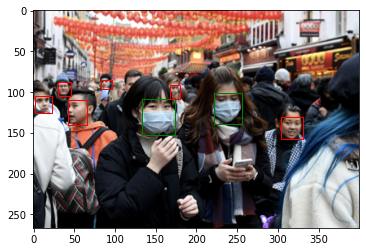

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0')


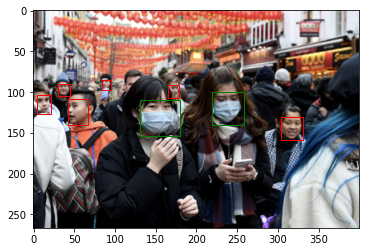

In [ ]:
# 예측된 결과를 이용해 이미지 위에 바운딩 박스를 그려봄
# 위에서 정의한 plot_image_from_output()함수로 그림을 출력함
# Target이 실제 바운딩 박스 위치,, Prediction이 모델이 예측한 결과

_idx = 1

# 실제 바운딩 박스 위치
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])

# 모델이 예측한 바운딩 박스 위치 결과
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

## STEP 6. 평가
* 전체 시험 데이터에 대해 예측 결과를 평가해 봄


### S6-1. 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 preds_adj_all, annot_all에 담아줌

In [ ]:
# 모든 시험 데이터에 대한 예측 결과와 실제 label을 
# 각각 preds_adj_all, annot_all에 담아줌

from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:10<00:00,  7.92it/s]


### S6-2. mAP값을 산출
* Tutorial-Book-Utils 폴더 내에 있는 utils_ObejctDetection.py 파일을 통해 mAP값을 산출

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
# get_batch_statistics 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 
# 바운딩 박스간의 통곗값을 계산후
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

# ap_per_class 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.721343731053274
AP : tensor([0.8531, 0.9263, 0.3846], dtype=torch.float64)


## 회고

* AP값은 background 클래스를 제외한 실제 3개의 클래스에 대해서만 보여줍니다. 

* 10번만 학습했음에도 불구하고 4장의 RetinaNet 결과보다 향상된 것을 확인할 수 있습니다. 

* 특히나 1번 클래스인 마스크 착용 객체에 대해서는 0.9189 AP에 해당하는 정확도까지 보이고 2번 클래스인 마스크를 제대로 착용하고 있지 않는 객체에서도 0.3664 AP를 보이고 있습니다. 

* RetinaNet이 FPN과 Focal loss로 one-stage method임에도 높은 성능을 보인다고 일반적으로 알려져 있습니다. 

* 물론 하이퍼파라미터 튜닝을 통해 RetinaNet의 성능을 최적화 해도 되겠지만, 현재 실험 결과로 미뤄봤을 때 이 데이터셋에는 Faster-RCNN이 더 좋은 성능을 보이고 있습니다.